# Mapping LAPD's 'Part I' crimes

### Import data tools

In [1]:
import pandas as pd
import geopandas as gpd
import pyarrow
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import weightedcalcs as wc
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Read crimes CSV downloaded from LA City data portal

In [2]:
# data exported from '00-lapd-crimes-processing.ipynb'
crimes = pd.read_feather('/Users/mhustiles/data/data/LA/crimes.feather')

In [3]:
crimes.head()

,index,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitude,year,quarter,day,month,weekday,monthname,descent_description,hour,minute,part_category
0,4,100100501,2010-01-03,2010-01-02,2100,1,Central,176,1,122,"Rape, attempted",0400,47,female,H,103,Alley,400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,122,nan,nan,nan,8TH ST,SAN PEDRO ST,34.0387,-118.2488,2010,1,2,1,Saturday,January,hispanic,21,00,pt_one_violent
1,5,100100506,2010-01-05,2010-01-04,1650,1,Central,162,1,442,Shoplifting - petty theft ($950 & under),0344 1402,23,male,B,404,Department store,nan,None,AA,adult_arrest,442,nan,nan,nan,700 W 7TH ST,None,34.0480,-118.2577,2010,1,4,1,Monday,January,black,16,50,pt_one_property
2,6,100100508,2010-01-08,2010-01-07,2005,1,Central,182,1,330,Burglary from vehicle,0344,46,male,H,101,Street,nan,None,IC,invest_cont,330,nan,nan,nan,PICO BL,GRAND AV,34.0389,-118.2643,2010,1,7,1,Thursday,January,hispanic,20,05,pt_one_property
3,7,100100509,2010-01-09,2010-01-08,2100,1,Central,157,1,230,"Assault with deadly weapon, aggravated assault",0416,51,male,B,710,Other premise,500.0,Unknown weapon/other weapon,AA,adult_arrest,230,nan,nan,nan,500 CROCKER ST,None,34.0435,-118.2427,2010,1,8,1,Friday,January,black,21,00,pt_one_violent
4,8,100100510,2010-01-09,2010-01-09,0230,1,Central,171,1,230,"Assault with deadly weapon, aggravated assault",0400 0416,30,male,H,108,Parking lot,400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,230,nan,nan,nan,800 W OLYMPIC BL,None,34.0450,-118.2640,2010,1,9,1,Saturday,January,hispanic,02,30,pt_one_violent


### Just this year

In [4]:
crimes_2019 = crimes[crimes.year == '2019']

In [5]:
len(crimes_2019)

123143

---

## Mapping data

In [6]:
# Transform our crimes data into a geoDataFrame
crimes_gdf = gpd.GeoDataFrame(crimes, \
    geometry=gpd.points_from_xy(crimes.longitude, crimes.latitude))

In [7]:
crimes_gdf.crs = ({'init': 'epsg:4326'})
crimes_gdf.to_crs({'init': 'epsg:4326'})

,index,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitude,year,quarter,day,month,weekday,monthname,descent_description,hour,minute,part_category,geometry
0,4,100100501,2010-01-03,2010-01-02,2100,1,Central,176,1,122,"Rape, attempted",0400,47,female,H,103,Alley,400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,122,nan,nan,nan,8TH ST,SAN PEDRO ST,34.0387,-118.2488,2010,1,2,1,Saturday,January,hispanic,21,00,pt_one_violent,POINT (-118.2488 34.0387)
1,5,100100506,2010-01-05,2010-01-04,1650,1,Central,162,1,442,Shoplifting - petty theft ($950 & under),0344 1402,23,male,B,404,Department store,nan,None,AA,adult_arrest,442,nan,nan,nan,700 W 7TH ST,None,34.0480,-118.2577,2010,1,4,1,Monday,January,black,16,50,pt_one_property,POINT (-118.2577 34.048)
2,6,100100508,2010-01-08,2010-01-07,2005,1,Central,182,1,330,Burglary from vehicle,0344,46,male,H,101,Street,nan,None,IC,invest_cont,330,nan,nan,nan,PICO BL,GRAND AV,34.0389,-118.2643,2010,1,7,1,Thursday,January,hispanic,20,05,pt_one_property,POINT (-118.2643 34.0389)
3,7,100100509,2010-01-09,2010-01-08,2100,1,Central,157,1,230,"Assault with deadly weapon, aggravated assault",0416,51,male,B,710,Other premise,500.0,Unknown weapon/other weapon,AA,adult_arrest,230,nan,nan,nan,500 CROCKER ST,None,34.0435,-118.2427,2010,1,8,1,Friday,January,black,21,00,pt_one_violent,POINT (-118.2427 34.0435)
4,8,100100510,2010-01-09,2010-01-09,0230,1,Central,171,1,230,"Assault with deadly weapon, aggravated assault",0400 0416,30,male,H,108,Parking lot,400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,230,nan,nan,nan,800 W OLYMPIC BL,None,34.0450,-118.2640,2010,1,9,1,Saturday,January,hispanic,02,30,pt_one_violent,POINT (-118.264 34.045)
5,9,100100511,2010-01-09,2010-01-06,2100,1,Central,132,1,341,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",0344 1402,55,male,W,710,Other premise,nan,None,IC,invest_cont,341,998,nan,nan,200 S OLIVE ST,None,34.0538,-118.2488,2010,1,6,1,Wednesday,January,white,21,00,pt_one_property,POINT (-118.2488 34.0538)
6,11,100100522,2010-01-15,2010-01-14,2000,1,Central,158,1,210,Robbery,0344,40,male,H,101,Street,400.0,"Strong-arm (hands, fist, feet or bodily force)",AO,adult_other,210,nan,nan,nan,ALAMEDA ST,7TH ST,34.0350,-118.2386,2010,1,14,1,Thursday,January,hispanic,20,00,pt_one_violent,POINT (-118.2386 34.035)
7,14,100100531,2010-01-16,2010-01-15,2030,1,Central,127,1,210,Robbery,0344 0416 1218,47,male,A,102,Sidewalk,400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,210,nan,nan,nan,1ST,LOS ANGELES,34.0515,-118.2424,2010,1,15,1,Friday,January,asian,20,30,pt_one_violent,POINT (-118.2424 34.0515)
8,17,100100553,2010-01-23,2010-01-23,1100,1,Central,166,1,210,Robbery,0344 0416,50,male,W,101,Street,400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,210,nan,nan,nan,600 SAN JULIAN ST,None,34.0428,-118.2461,2010,1,23,1,Saturday,January,white,11,00,pt_one_violent,POINT (-118.2461 34.0428)
9,18,100100555,2010-01-23,2010-01-23,2000,1,Central,132,1,236,Intimate partner - aggravated assault,2000,18,female,W,502,"Multi-unit dwelling (apartment, duplex, etc)",400.0,"Strong-arm (hands, fist, feet or bodily force)",IC,invest_cont,236,nan,nan,nan,200 S GRAND AV,None,34.0545,-118.2499,2010,1,23,1,Saturday,January,white,20,00,pt_one_violent,POINT (-118.2499 34.0545)


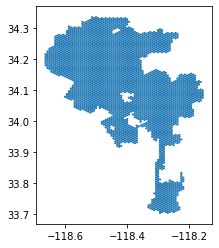

In [8]:
# Read a half-mile hexbin grid
halfmile = gpd.read_file('input/halfmile.geojson')
halfmile['geometry'] = halfmile['geometry'].to_crs(epsg=4326)
halfmile.plot()

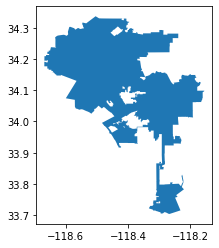

In [9]:
# Read city of Los Angeles boundary file
la = gpd.read_file('input/la_city_boundary/la_city_boundary_1570551157861.geojson')
la.plot()

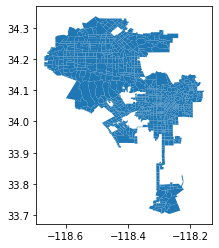

In [10]:
# Read LAPD reporting districts
districts = gpd.read_file('input/LAPD_Reporting_Districts/LAPD_Reporting_Districts.shp')
districts.plot()

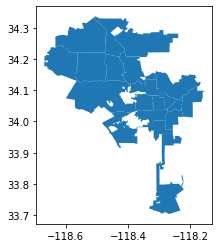

In [11]:
# Read LAPD divisions
divisions = gpd.read_file('input/LAPD_Divisions/LAPD_Divisions.shp')
divisions.plot()

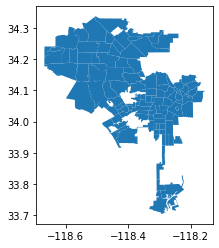

In [12]:
# Read LA Times neighborhoods
hoods = gpd.read_file('input/custom-la-hoods-skid-row.geojson')
hoods.plot()

---

## Basic aggregates on variables for all crimes

### Which crimes are most common? 

In [13]:
violations = crimes.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [14]:
violations.head(10)

,crime_code_description,total
9,Burglary from vehicle,162050
54,Vehicle - stolen,159722
42,Theft plain - petty ($950 & under),149561
8,Burglary,147409
2,"Assault with deadly weapon, aggravated assault",92632
39,Theft from motor vehicle - petty ($950 & under),88368
29,Robbery,83813
47,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",74299
32,Shoplifting - petty theft ($950 & under),48380
38,Theft from motor vehicle - grand ($400 and over),31605


### Places where crimes occur?

In [15]:
places = crimes.groupby(['premises_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [16]:
places.head(10)

,premises_description,total
273,Street,358571
262,Single family dwelling,146704
229,Parking lot,115353
207,"Multi-unit dwelling (apartment, duplex, etc)",85681
261,Sidewalk,61525
220,Other business,50238
64,Driveway,34295
80,Garage/carport,33409
56,Department store,26478
108,Market,18316


### Aggregates for police geography

In [17]:
divisions = crimes.groupby(['division', 'division_name', 'crime_code_description', 'year'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [18]:
divisions.head()

,division,division_name,crime_code_description,year,total
5625,3,Southwest,Theft plain - petty ($950 & under),2013,1628
1520,12,77th Street,Vehicle - stolen,2016,1625
5624,3,Southwest,Theft plain - petty ($950 & under),2012,1617
1521,12,77th Street,Vehicle - stolen,2017,1564
2356,15,N Hollywood,Burglary from vehicle,2010,1560


In [19]:
districts = crimes.groupby(['reporting_district', 'division_name','crime_code_description','year'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [20]:
districts.head()

,reporting_district,division_name,crime_code_description,year,total
116911,363,Southwest,Shoplifting - petty theft ($950 & under),2015,433
116957,363,Southwest,Theft plain - petty ($950 & under),2012,430
43096,1494,Pacific,"Theft-grand ($950.01 & over)excpt,guns,fowl,li...",2010,420
102469,2156,Topanga,Shoplifting - petty theft ($950 & under),2011,418
116958,363,Southwest,Theft plain - petty ($950 & under),2013,388


---